<a href="https://colab.research.google.com/github/tonygms2/CSE499/blob/main/DCGAN_For_Bangla_Numeral_Handwritten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import tqdm.notebook as tq
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from torchvision import datasets,transforms
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

#setting manual seed to get a consistent output 
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed) 

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


writer_disc = SummaryWriter()
writer_gen = SummaryWriter()
writer_mean_gen = SummaryWriter()
writer_mean_disc = SummaryWriter()

In [ ]:
#Generator
class Generator(nn.Module):
    
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace = True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    
        return torch.randn(n_samples, z_dim, device=device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

#  Discriminator
class Discriminator(nn.Module):
   
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.01,inplace=True)

            )
        else: 
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                nn.LeakyReLU(0.01)

            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:
gen = Generator()
disc = Discriminator()
print(gen)
print(disc)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 100
display_step = 500
batch_size = 128

lr = 0.0002
num_workers=4

beta_1 = 0.5 
beta_2 = 0.999
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.Grayscale(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                
])




In [ ]:

trainData = datasets.ImageFolder('/content/drive/MyDrive/Dataset/Numeral',transform=train_transform)



In [ ]:
dataloader = DataLoader(trainData,batch_size=batch_size,shuffle=True,num_workers=num_workers)
dataloader.dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1, 28, 28])


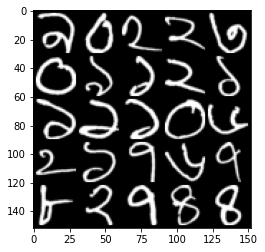

In [ ]:
images,labels = next(iter(dataloader))
images.size
print(images[0].shape)
show_tensor_images(images)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
gen_opt.load_state_dict(torch.load('./drive/MyDrive/Saved Model/generatorOptimizerSaves.pt'))

disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_opt.load_state_dict(torch.load('./drive/MyDrive/Saved Model/discriminatorOptimizerSaves.pt'))

gen.load_state_dict(torch.load('./drive/MyDrive/Saved Model/generatorSaves.pt'))
#gen.eval()
disc.load_state_dict(torch.load('./drive/MyDrive/Saved Model/discriminatorSaves.pt'))
#disc.eval()

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
#gen = gen.apply(weights_init) #uncomment this code on first run
#disc = disc.apply(weights_init) #uncomment this code on first run. 

gen.train()
disc.train()
print(gen)
print(disc)
summary(disc,(1,28,28))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Number of epoch :3, Step 500: Generator loss: 0.6676174277663236, discriminator loss: 0.6749686235189429


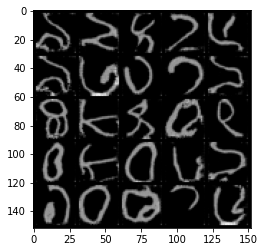

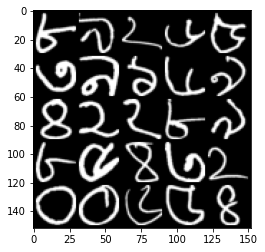

Number of epoch :7, Step 1000: Generator loss: 0.6885523383617397, discriminator loss: 0.6867048118114467


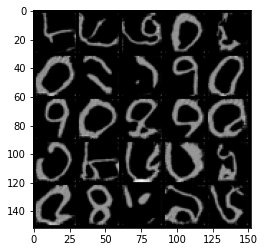

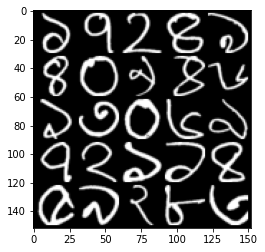

Number of epoch :11, Step 1500: Generator loss: 0.6786471749544135, discriminator loss: 0.6807206110954291


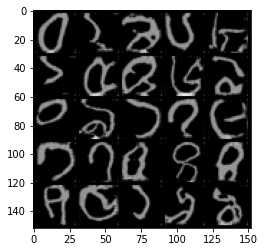

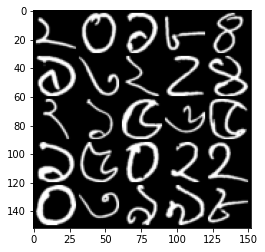

Number of epoch :15, Step 2000: Generator loss: 0.6717594287395476, discriminator loss: 0.678308288097382


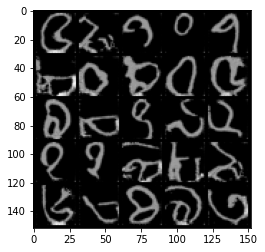

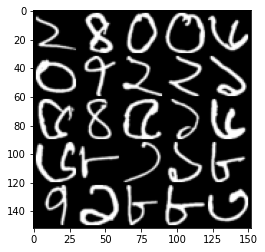

Number of epoch :18, Step 2500: Generator loss: 0.671245692133904, discriminator loss: 0.6769010678529742


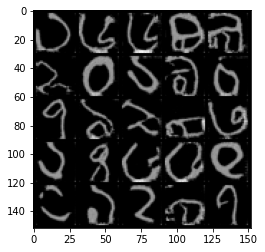

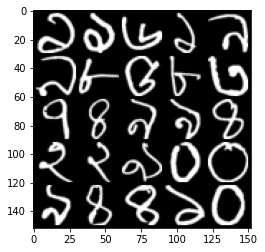

Number of epoch :22, Step 3000: Generator loss: 0.6877684478759767, discriminator loss: 0.686556139349938


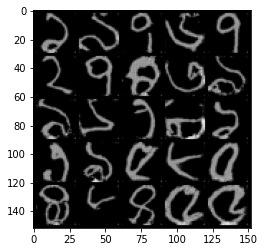

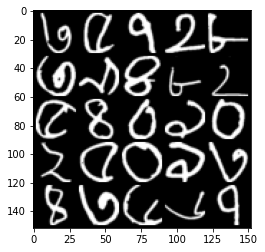

Number of epoch :26, Step 3500: Generator loss: 0.6679703475236891, discriminator loss: 0.6758930131196978


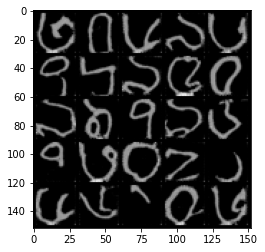

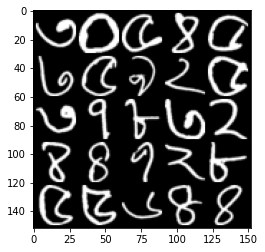

Number of epoch :30, Step 4000: Generator loss: 0.6637297503948208, discriminator loss: 0.6752030540704725


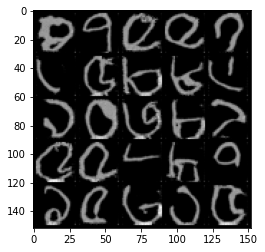

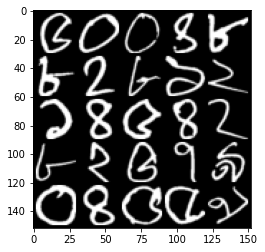

Number of epoch :34, Step 4500: Generator loss: 0.6713740528821945, discriminator loss: 0.6783347541093823


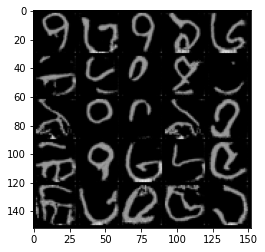

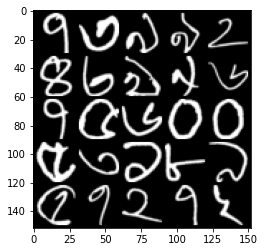

Number of epoch :37, Step 5000: Generator loss: 0.6765331046581272, discriminator loss: 0.6822565189599986


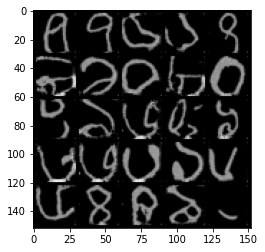

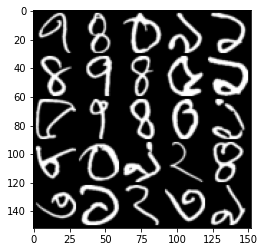

Number of epoch :41, Step 5500: Generator loss: 0.6735245983600614, discriminator loss: 0.6781787378787995


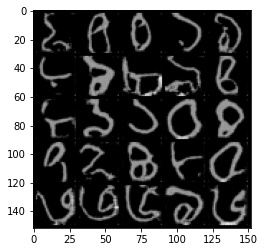

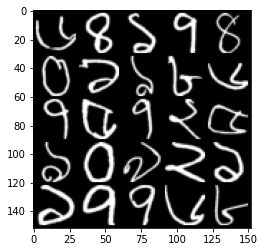

Number of epoch :45, Step 6000: Generator loss: 0.665015977978707, discriminator loss: 0.6766168503761294


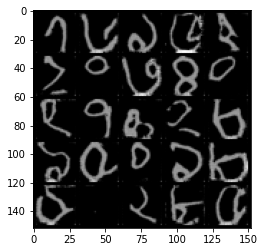

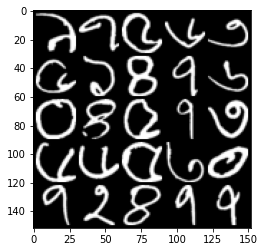

Number of epoch :49, Step 6500: Generator loss: 0.6690197461843496, discriminator loss: 0.6750051524639135


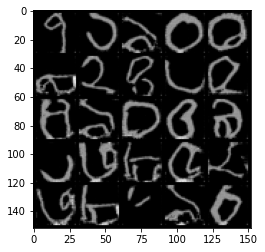

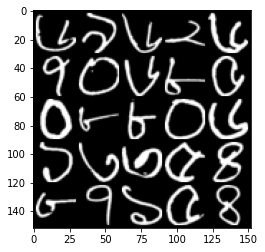

Number of epoch :53, Step 7000: Generator loss: 0.6681774208545691, discriminator loss: 0.677097650885582


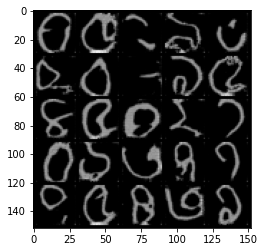

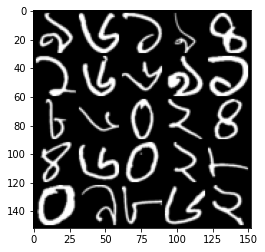

Number of epoch :56, Step 7500: Generator loss: 0.6759907263517384, discriminator loss: 0.6810225389003752


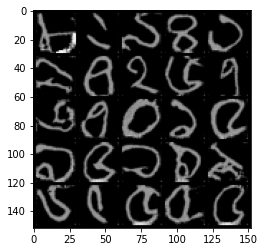

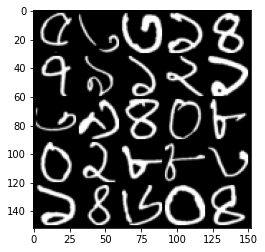

Number of epoch :60, Step 8000: Generator loss: 0.6679380453824991, discriminator loss: 0.6778669940233232


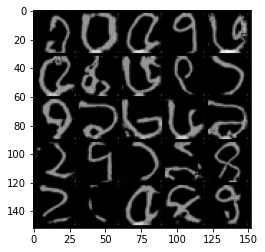

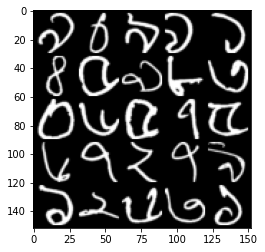

Number of epoch :64, Step 8500: Generator loss: 0.6744588086605074, discriminator loss: 0.6797739559412002


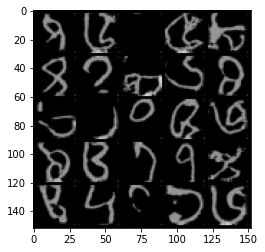

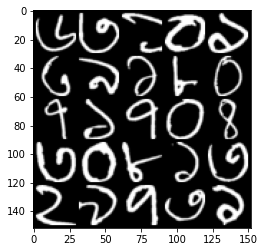

In [ ]:
n_epochs = 1000
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in tq.trange(n_epochs):
    # Dataloader returns the batches
    for real, _ in (dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        writer_disc.add_scalar("Discriminator Loss/train",disc_loss,epoch)

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        writer_gen.add_scalar("Generator Loss/train",gen_loss,epoch)
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        torch.save(gen.state_dict(),'./drive/MyDrive/Saved Model/generatorSaves.pt')
        torch.save(gen_opt.state_dict(),'./drive/MyDrive/Saved Model/generatorOptimizerSaves.pt')
        torch.save(disc.state_dict(),'./drive/MyDrive/Saved Model/discriminatorSaves.pt')
        torch.save(disc_opt.state_dict(),'./drive/MyDrive/Saved Model/discriminatorOptimizerSaves.pt')
        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Number of epoch :{epoch}, Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            writer_mean_gen.add_scalar("Mean Generator Loss",mean_generator_loss,epoch)
            writer_mean_disc.add_scalar("Mean Discriminator Loss",mean_discriminator_loss,epoch)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


In [ ]:
writer_disc.flush()
writer_gen.flush()
writer_mean_disc.flush()
writer_mean_gen.flush()

In [ ]:
torch.save(gen.state_dict(),'./drive/MyDrive/Saved Model/generatorDebug.pt') #8th save 9th may 2021
torch.save(gen_opt.state_dict(),'./drive/MyDrive/Saved Model/generatorOptimizerDebug.pt')
torch.save(disc.state_dict(),'./drive/MyDrive/Saved Model/discriminatorDebug.pt')
torch.save(disc_opt.state_dict(),'./drive/MyDrive/Saved Model/discriminatorOptimizerDebug.pt')

In [ ]:
torch.save(gen.state_dict(),'./drive/MyDrive/Saved Model/generatorDebug.pt') #8th save 9th may 2021
torch.save(gen_opt.state_dict(),'./drive/MyDrive/Saved Model/generatorOptimizerDebug.pt')
torch.save(disc.state_dict(),'./drive/MyDrive/Saved Model/discriminatorDebug.pt')
torch.save(disc_opt.state_dict(),'./drive/MyDrive/Saved Model/discriminatorOptimizerDebug.pt')

In [ ]:
#upload tensorboard
!tensorboard dev upload --logdir ./runs \
  --name "Data 3870 epoch" \
  --one_shot